### Imports

In [6]:
import openai
from rich import print
from getpass import getpass

oai_api_key = getpass()

### Basic Prompting

We'll be using the OpenAI Python SDK. Using `gpt-3.5-turbo` & `gpt-4.1`, which has 1M input tokens interchangably.

In [7]:
client = openai.Client(api_key=oai_api_key)

response = client.responses.create(
    model="gpt-4.1-mini", input="Write a simple email about asking for leave."
)

print(response.output_text)

Subject: Request for Leave

Dear [Manager's Name],

I hope this email finds you well. I would like to request leave from  to  due to . 

Please let me know if you need any additional information. I will ensure that all my pending tasks are completed 
before my leave.

Thank you for your understanding.

Best regards,  
[Your Name]

#### Instruction Following Prompt

In [ ]:
response = client.responses.create(
    model="gpt-3.5-turbo",
    instructions="You are an employee in a small scale Indian company, where managers are quite strict. Make it very formal \
    and convincing and verbose.",
    input="Write a simple email about asking for leave.",
)

print(response.output_text)

#### Chain of Thought

In [ ]:
response = client.responses.create(
    model="gpt-3.5-turbo",
    instructions="You are an employee in a small scale Indian company, where managers are quite strict. Make it very formal \
    and convincing and verbose.",
    input="Write a simple email about asking for leave. Plan step by step and think carefully.",
)

print(response.output_text)

In [ ]:
response = client.responses.create(
    model="gpt-4.1-mini",
    instructions="You are an employee in a small scale Indian company, where managers are quite strict. Make it very formal \
    and convincing and verbose.",
    input="Write a simple email about asking for leave. Plan step by step and think carefully.",
)

print(response.output_text)

#### If I want to get a json response with these how do I get it?

```json

{
    "subject": "....",
    "body": "...",
    "designation": "",
    "contact_info": "",
}
```

# multi line prompt use """ """"
"""

"""

In [ ]:
response = client.responses.create(
    model="gpt-4.1-mini",
    instructions="""You are an employee in a small scale Indian company, where managers are quite strict. Make it very formal \
    and convincing and verbose. I need the data in the following json format \
    {
    "subject": "....",
    "body": "...",
    "designation": "",
    "contact_info": "",
    "age": ""
    }""",
    input="Write a simple email about asking for leave.",
)

print(response.output_text)

In [9]:
def parser(output_text):
    """
        Do parsing here
    """
    pass

In [ ]:
parser(response.output_text)

### Enter Structured Outputs


Most of the other models + sdks have a similar set of prompting fundamentals. Next set of steps would be the same.

Till this point, everyone used to work with the similar responses. There were issues, a lot of them:

1. Prompt responses were just text
2. You "could" get a json response, but even then it was very inconsistent.
3. Building on top of text for applications becomes more difficult.
4. Writing evalulations/test against these is also nasty work.

Thankfully, all the providers now provide solutions to structured outputs (Very recent: Aug, 2024 release). Here's a [github-repo](https://github.com/imaurer/awesome-llm-json) for an overview about llms with json outputs.

JSON being the lingua-franca of the web space. (Not Jason Statham)

![json-statham](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTJzk-4jdjQnm7Sqi2_BPLZ2dLBEaTK51uGfQ&s)

This JSON

![json](https://code.visualstudio.com/assets/docs/languages/json/json_hero.png)

There are 2 ways to get structured outputs:

1. JSON Mode embedded in the LLM calling: OpenAI, , DeepSeek (and a few others have json mode) having varying degrees of reliability. OpenAI themselves 
2. Function calling: Newer, more powerful way to get much better outputs with tools (web search, code editor, etc).

Both the above are paired with data validation/typing libraries in Python (Pydantic) and Zod (JS) to get standardized outputs. OpenAI and most other providers have their SDKs working with Pydantic.

### Using Pydantic

Python has internal `dataclasses` and `types` now, but still aren't enforced at runtime. To get to a place where custom types are easy to implement, Pydantic was the first library that let us do it.

#### [Detour] Why do we use types in programming?

- Auto-completion in the IDE (though one would argue that cursor `tabs` now fix these issues).
- You know what is the output looking at the function definition. Easier to debug for you as well as LLM.



#### Function

In [15]:
def process_items(prices: dict[str, float]):
    for item_name, item_price in prices.items():
        print(item_name, item_price)

In [ ]:
process_items({"apple": 1.5, "banana": 2.0})

In [ ]:
process_items({"apple": 1.0, "banana": "pratos"})

#### Pydantic Example

In [20]:
from typing import Annotated

from annotated_types import Gt

from pydantic import BaseModel

In [27]:
class FruitPrice(BaseModel):
    name: str
    price: float


fruit1 = FruitPrice(name="Apple", price=1.0)
fruit2 = FruitPrice(name="Banana", price=2.0)

In [ ]:
print(fruit1)

In [ ]:
type(fruit1)

In [ ]:
fruit1.name

In [ ]:
fruit1.price

In [25]:
def process_items(prices: list[FruitPrice]) -> None:
    for item in prices:
        print(type(item))
        print(item.name, item.price)

In [ ]:
process_items([fruit1, fruit2])

In [ ]:
class FruitPrice(BaseModel):
    name: str
    price: float

In [32]:
class FruitPrice(BaseModel):
    name: str
    price: Annotated[float, Gt(1.0)]

In [ ]:
def process_items(prices: list[FruitPrice]) -> None:
    for item in prices:
        print(item.name, item.price)


fruit1 = FruitPrice(name="Apple", price=0.9)
fruit2 = FruitPrice(name="Banana", price=2.0)
process_items([fruit1, fruit2])

You can increase the complexity of the model by adding more fields or combining two different types.


In [ ]:
from typing import Annotated
from enum import Enum

class FruitColor(Enum):
    RED = "red"
    GREEN = "green"

class FruitTasteMeter(BaseModel):
    sweetness: float
    sourness: float
    bitterness: float

class FruitInfo(BaseModel):
    name: str
    price: float
    color: FruitColor
    weight: Annotated[float, Gt(0)]
    taste: FruitTasteMeter

fruit1 = FruitInfo(name="Apple", price=0.9, color=FruitColor.RED, weight=1.0, \
    taste=FruitTasteMeter(sweetness=0.9, sourness=0.1, bitterness=0.0))

print(fruit1)

We can also have validations like these, various flavours of type validation.

You can look at pydantic's documentation -> [click here](https://docs.pydantic.dev/latest/)

In [ ]:
from pydantic import BaseModel, field_validator
from typing import Annotated
import instructor


class UserProfile(BaseModel):
    name: str
    email: str
    age: int

    @field_validator("email")
    @classmethod
    def validate_email(cls, v):
        if "@" not in v:
            raise ValueError("Invalid email format")
        return v.lower()

    @field_validator("age")
    @classmethod
    def validate_age(cls, v):
        if v < 0 or v > 150:
            raise ValueError("Age must be between 0 and 150")
        return v


# Test the validators
try:
    user = UserProfile(name="John", email="JOHN@EXAMPLE.COM", age=-5)
    print(f"Valid user: {user}")
    print(f"Email normalized: {user.email}")
except Exception as e:
    print(f"Validation error: {e}")

These nice little properties can be leveraged in getting structured outputs with `OpenAI`.

- Below is an example using the JSON Mode. I've copy pasted content from this [website page](https://fbref.com/en/players/bc7dc64d/Bukayo-Saka)


In [38]:
user_content = """Statistic	Per 90	Percentile
Non-Penalty Goals	0.28	57  
npxG: Non-Penalty xG	0.31	77  
Shots Total	4.22	99  
Assists	0.37	89  
xAG: Exp. Assisted Goals	0.38	96  
npxG + xAG	0.69	92  
Shot-Creating Actions	5.58	93  
Passes Attempted	46.94	83  
Pass Completion %	75.1%	47  
Progressive Passes	4.89	75  
Progressive Carries	5.78	96  
Successful Take-Ons	4.77	99  
Touches (Att Pen)	7.02	92  
Progressive Passes Rec	13.84	97
Tackles	1.35	57  
Interceptions	0.46	57  
Blocks	0.53	14  
Clearances	0.11	1  
Aerials Won	0.05	1  """

In [35]:
class AttackingAttributes(BaseModel):
    total_goals: float
    passes_attempted: float
    passes_completed: float
    pass_completion_percentage: float
    xAG: float
    xG: float
    takeons: float


class DefensiveAttributes(BaseModel):
    tackles: float
    interceptions: float
    blocks: float
    clearances: float
    aerials_won: float


class PlayerAttributes(BaseModel):
    attacking: AttackingAttributes
    defensive: DefensiveAttributes

Pydantic also gives a nifty json schema that can be used with JSON Mode in OpenAI

In [ ]:
PlayerAttributes.model_json_schema()

In [37]:
json_schema = PlayerAttributes.model_json_schema()

In [39]:
completion = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
        {
            "role": "system",
            "content": f"""You are an expert at structured data extraction. \
You will be given unstructured text from a page and should convert it into the given structure.

JSON schema:
{json_schema}""",
        },
        {"role": "user", "content": f"{user_content}"},
    ],
    response_format={"type": "json_object"},
)

In [ ]:
print(completion)

In [ ]:
print(completion.choices[0])

In [ ]:
print(completion.choices[0].message.content)

| Statistic                 | Per 90 | Percentile |
|---------------------------|--------|------------|
| Non-Penalty Goals         | 0.28   | 57         |
| npxG: Non-Penalty xG      | 0.31   | 77         |
| Shots Total               | 4.22   | 99         |
| Assists                   | 0.37   | 89         |
| xAG: Exp. Assisted Goals  | 0.38   | 96         |
| npxG + xAG                | 0.69   | 92         |
| Shot-Creating Actions     | 5.58   | 93         |
| Passes Attempted          | 46.94  | 83         |
| Pass Completion %         | 75.1%  | 47         |
| Progressive Passes        | 4.89   | 75         |
| Progressive Carries       | 5.78   | 96         |
| Successful Take-Ons       | 4.77   | 99         |
| Touches (Att Pen)         | 7.02   | 92         |
| Progressive Passes Rec    | 13.84  | 97         |
| Tackles                   | 1.35   | 57         |
| Interceptions             | 0.46   | 57         |
| Blocks                    | 0.53   | 14         |
| Clearances                | 0.11   | 1          |
| Aerials Won               | 0.05   | 1          |



Pretty impressive, but too much hassle to get to the schema and getting the parsed content out. This was for older models. For new models:


In [47]:
# Using Responses API for structured outputs
response = client.responses.parse(
    model="gpt-4o-mini",
    input=f"{user_content}",
    text_format=PlayerAttributes,
)

In [ ]:
print(response.output_parsed)

In [ ]:
print(type(response.output_parsed))

This is a response format in text, but we can get it directly in the pydantic format

In [51]:
# Using Responses API for structured outputs
response = client.responses.parse(
    model="gpt-4o-mini",
    instructions=f"""You are an expert at structured data extraction. \
You will be given unstructured text from a website and should convert it into the given structure.""",
    input=f"{user_content}",
    text_format=PlayerAttributes,
)

In [ ]:
print(response.output_parsed)

#### Pydantic Validation Example

We can add validations like below, if we manage to get no outputs for a player


In [53]:
from pydantic import BaseModel, model_validator


class PlayerAttributes(BaseModel):
    attacking: AttackingAttributes
    defensive: DefensiveAttributes

    @model_validator(mode="after")
    def overall_checks(self):
        total_actions = (
            self.attacking.passes_attempted
            + self.attacking.takeons
            + self.defensive.tackles
            + self.defensive.interceptions
            + self.defensive.blocks
            + self.defensive.clearances
            + self.defensive.aerials_won
        )

        if total_actions == 0:
            raise ValueError(
                "Player attributes imply no activity at all, check input data."
            )

        return self

In [54]:
user_content = """
Statistic	Per 90	Percentile
Non-Penalty Goals	0.00	0
npxG: Non-Penalty xG	0.00	0
Shots Total	0.00	0
Assists	0.00	0
xAG: Exp. Assisted Goals	0.00	0
npxG + xAG	0.00	0
Shot-Creating Actions	0.00	0
Passes Attempted	0.00	0
Pass Completion %	0%	0
Progressive Passes	0.00	0
Progressive Carries	0.00	0
Successful Take-Ons	0.00	0
Touches (Att Pen)	0.00	0
Progressive Passes Rec	0.00	0
Tackles	0.00	0
Interceptions	0.00	0
Blocks	0.00	0
Clearances	0.00	0
Aerials Won	0.00	0
"""

In [ ]:
try:
    response = client.responses.parse(
            model="gpt-4o-mini",
            instructions=f"""You are an expert at structured data extraction. \
    You will be given unstructured text from a website and should convert it into the given structure.""",
            input=f"{user_content}",
            text_format=PlayerAttributes,
        )
except Exception as e:
    print(e)

So, as you can see this is great! LLMs + Structured Outputs = Nice outputs that can be provided to other services. 

Services can be:

- Another API
- Another or the same LLM
- To another tool
- Pushed to a code generator (Generate React Code for UI like Loveable)
- Directly to DB
- To another MCP 

---

#### There's a small mistake in the code above

Can you try and find it?


---


### Instructor

Now we won't be using the original model SDK's, instead working with higher abstractions.

Link to instructor -> [click here](https://python.useinstructor.com/)

- One of them is `instructor`, it is based on Pydantic and steers the json output to be correct all the time. It won't exactly do everything in one go as promised, but it lets you play with multiple providers + pydantic classes magic.


In [10]:
import instructor

ins_client = instructor.from_openai(client)

In [58]:
class Person(BaseModel):
    name: float
    age: int

In [59]:
person = ins_client.chat.completions.create(
    model="gpt-4.1",
    response_model=Person,
    messages=[
        {"role": "system", "content": "You are a dumbass"},
        {"role": "user", "content": "John Quito is 12 years old"},
    ],
)

In [ ]:
print(person)

In [37]:
from typing import Optional


class Person(BaseModel):
    name: Optional[str] = None
    age: int

In [38]:
person = ins_client.chat.completions.create(
    model="gpt-3.5-turbo",
    response_model=Person,
    messages=[{"role": "user", "content": "he is 30 years old"}],
)

In [ ]:
print(person)

You can play around the above example and try to break it

In [61]:
user_content = """Statistic	Per 90	Percentile
Non-Penalty Goals	0.28	57  
npxG: Non-Penalty xG	0.31	77  
Shots Total	4.22	99  
Assists	0.37	89  
xAG: Exp. Assisted Goals	0.38	96  
npxG + xAG	0.69	92  
Shot-Creating Actions	5.58	93  
Passes Attempted	46.94	83  
Pass Completion %	75.1%	47  
Progressive Passes	4.89	75  
Progressive Carries	5.78	96  
Successful Take-Ons	4.77	99  
Touches (Att Pen)	7.02	92  
Progressive Passes Rec	13.84	97  
Tackles	1.35	57  
Interceptions	0.46	57  
Blocks	0.53	14  
Clearances	0.11	1  
Aerials Won	0.05	1  """

In [62]:
player_info = ins_client.chat.completions.create(
    model="gpt-3.5-turbo",
    response_model=PlayerAttributes,
    messages=[{"role": "user", "content": f"{user_content}"}],
)

In [ ]:
print(player_info)

| Statistic                 | Per 90 | Percentile |
|---------------------------|--------|------------|
| Non-Penalty Goals         | 0.28   | 57         |
| npxG: Non-Penalty xG      | 0.31   | 77         |
| Shots Total               | 4.22   | 99         |
| Assists                   | 0.37   | 89         |
| xAG: Exp. Assisted Goals  | 0.38   | 96         |
| npxG + xAG                | 0.69   | 92         |
| Shot-Creating Actions     | 5.58   | 93         |
| Passes Attempted          | 46.94  | 83         |
| Pass Completion %         | 75.1%  | 47         |
| Progressive Passes        | 4.89   | 75         |
| Progressive Carries       | 5.78   | 96         |
| Successful Take-Ons       | 4.77   | 99         |
| Touches (Att Pen)         | 7.02   | 92         |
| Progressive Passes Rec    | 13.84  | 97         |
| Tackles                   | 1.35   | 57         |
| Interceptions             | 0.46   | 57         |
| Blocks                    | 0.53   | 14         |
| Clearances                | 0.11   | 1          |
| Aerials Won               | 0.05   | 1          |


In [65]:
from typing import Optional

class AttackingAttributes(BaseModel):
    total_goals: float
    passes_attempted: float
    passes_completed: Optional[float]
    pass_completion_percentage: float
    xAG: float
    xG: float
    takeons: float


class DefensiveAttributes(BaseModel):
    tackles: float
    interceptions: float
    blocks: float
    clearances: float
    aerials_won: float


class PlayerAttributes(BaseModel):
    attacking: AttackingAttributes
    defensive: DefensiveAttributes

    @model_validator(mode="after")
    def overall_checks(self):
        total_actions = (
            self.attacking.passes_attempted
            + self.attacking.takeons
            + self.defensive.tackles
            + self.defensive.interceptions
            + self.defensive.blocks
            + self.defensive.clearances
            + self.defensive.aerials_won
        )

        if total_actions == 0:
            raise ValueError(
                "Player attributes imply no activity at all, check input data."
            )

        return self

In [ ]:
player_info = ins_client.chat.completions.create(
    model="gpt-3.5-turbo",
    response_model=PlayerAttributes,
    messages=[{"role": "user", "content": f"{user_content}"}],
)
print(player_info)

Tracking token usage

In [ ]:
player_info, completion = ins_client.chat.completions.create_with_completion(
    model="gpt-3.5-turbo",
    response_model=PlayerAttributes,
    messages=[{"role": "user", "content": f"{user_content}"}],
)
print(player_info)

In [ ]:
print(completion.usage)

---

#### [Detour]

there's a few validators that are extended in `instructor`

- `before`
- `after`
- `wrap`

There are 2 flavours of validators:
- `decorator` pattern
- `Annotated` pattern

Instructor uses the same patterns.

In [3]:
from pydantic import field_validator, model_validator
from pydantic import BaseModel

class Product(BaseModel):
    name: str
    email: str
    price: float
    discount: float = 0.0
    final_price: float = None

    @model_validator(mode="before")
    @classmethod
    def normalize_input(cls, values):
        # Before validation - clean the input
        if isinstance(values, dict):
            if "name" in values:
                values["name"] = values["name"].strip().title()
        return values

    @model_validator(mode="after")
    def calculate_final_price(self):
        # After validation - compute derived fields
        self.final_price = self.price * (1 - self.discount)
        return self

# Test before/after validators
product = Product(name="  laptop  ", price=1000, discount=0.1)
print(f"Product: {product.name}")
print(f"Price: ${product.price}, Discount: {product.discount * 100}%")
print(f"Final Price: ${product.final_price}")

Product: Laptop

Price: $1000.0, Discount: 10.0%

Final Price: $900.0

In [22]:
# LLM Validator example using instructor
from instructor import llm_validator
from pydantic import BeforeValidator, field_validator
from typing import Annotated

def normalize_confidence(value):
    """Convert percentage to decimal if needed"""
    # "10% -> 0.1"
    if isinstance(value, str) and value.endswith('%'):
        return float(value.rstrip('%')) / 100
    return float(value)


class ReviewAnalysis(BaseModel):
    sentiment: Annotated[
        str, 
        llm_validator("The sentiment must be either 'positive', 'negative', or \
            'neutral'. Convert synonyms. Fix English spelling errors. \
            Positive, Negative, Neutral are the only valid values.",
            client=ins_client),
    ]
    confidence: Annotated[float, BeforeValidator(normalize_confidence),
        llm_validator("The confidence must be between 0 and 1. Fix any spelling errors or convert synonyms.",
            client=ins_client)
    ]
    review_text: Annotated[
        str,
        llm_validator("""Analyze the review text for offensive, inappropriate, or unprofessional language including but not limited to:
- Profanity or curse words (damn, hell, sucks, crap, etc.)
- Vulgar or crude language
- Inappropriate slang
- Insulting or derogatory terms
- Any language that would be inappropriate in a professional setting

If ANY offensive language is detected, replace the ENTIRE text with 'N/A'. 
Examples:
- "This product sucks" → "N/A"
- "What a crappy design" → "N/A"  
- "Damn good product" → "N/A"
- "Great product, highly recommend" → "Great product, highly recommend" (no change)

Be strict in your assessment.""",
            client=ins_client),
    ]

In [23]:
review1 = ReviewAnalysis(
        sentiment="positive",
        confidence="85%",
        review_text="This product is awsome!"
    )
print(f"Review 1: {review1.sentiment}, Confidence: {review1.confidence}")
print(f"Cleaned text: {review1.review_text}")

Review 1: positive, Confidence: 0.85

Cleaned text: This product is awsome!

In [24]:
review2 = ReviewAnalysis(
    sentiment="good",
    confidence=0.92,
    review_text="Great product, highly recommend!",
)
print(f"Review 2: {review1.sentiment}, Confidence: {review2.confidence}")
print(f"Text: {review2.review_text}")

Review 2: positive, Confidence: 0.92

Text: Great product, highly recommend!

In [25]:
review2 = ReviewAnalysis(
    sentiment="good",
    confidence=0.92,
    review_text="Bad product don't recommend it to anyone it sucks",
)
print(f"Review 2: {review1.sentiment}, Confidence: {review2.confidence}")
print(f"Text: {review2.review_text}")

Review 2: positive, Confidence: 0.92

Text: Bad product don't recommend it to anyone it sucks

---

### Improving our Scouting Bot using a few more components

What do we need?

- Get the player url
- Scrape the data
- Send it to the model to fetch the right data
- Get the data and send it to a reasoning model to get our final answer?

In [70]:
bs7_url = "https://fbref.com/en/players/bc7dc64d/Bukayo-Saka"

In [ ]:
from getpass import getpass
from firecrawl import FirecrawlApp, ScrapeOptions

fc_api_key = getpass()

#### Firecrawl

- Using `https://www.firecrawl.dev/` we can scrape any content in any format that we want

In [ ]:
# scrape the data (FBRef has hostile scraping rules), hence using firecrawl

app = FirecrawlApp(api_key=fc_api_key)

# Scrape a website:
scrape_status = app.scrape_url(bs7_url, formats=["html"])

# scrape_status.html

In [77]:
# write the model
from typing import Literal, List, Optional
from pydantic import HttpUrl, BaseModel, Field
from enum import Enum

class SocialMedia(Enum):
    TWITTER: "Twitter"
    INSTAGRAM: "Instagram"

class SocialMediaInfo(BaseModel):
    handle: str
    sc_type: SocialMedia

class PlayerPersonal(BaseModel):
    name: Optional[str] = None
    profile_pic: Optional[HttpUrl] = None
    position: Optional[List[str]] = None
    foot: Literal["Left", "Right"] = None
    height: Optional[str]
    weight: Optional[str]
    birthday: Optional[str]
    birthplace: Optional[str]
    national_team: Optional[str]
    club: Optional[str]
    national_team: Optional[str]
    wages: Optional[str]
    contract_expiring_on: Optional[str]
    social_media: Optional[List[str]]

class AttackingStats(BaseModel):
    npg: float
    npg_percentile: int
    npxG: float
    npxG_percentile: int
    total_shots: float
    total_shots_percentile: int
    assists: float
    assists_percentile: int
    xAG: float
    xAG_percentile: int
    total_attacking_prowress: Optional[float] = Field(description="npXG + xAG")
    sca: Optional[float] = Field(description="Shot creating actions")
    sca_percentile: int
    passes_attempted: float
    passes_attempted_percentile: int
    pass_completion: float
    pass_completion_percentile: int
    progressive_passes: float
    progressive_passes_percentile: int
    progressive_carries: float
    progressive_carries_percentile: int
    successful_takeons: float
    successful_takeons_percentile: int
    touches: float
    touches_percentile: int


class DefensiveStats(BaseModel):
    tackles: float
    tackles_percentile: int
    interceptions: float
    interceptions_percentile: int
    blocks: float
    blocks_percentile: int
    clearances: float
    clearances_percentile: int
    aerials_won: float
    aerials_won_percentile: int


class SimilarPlayer(BaseModel):
    name: str
    url: Optional[HttpUrl]


class PlayerInfo(BaseModel):
    personal: PlayerPersonal
    attacking_stats: AttackingStats
    defensive_stats: DefensiveStats
    similar_players: List[SimilarPlayer] = Field(
        description="Comparing against Att Mid/Wingers with \
    tuple being Player Name and url of the player"
    )

In [ ]:
player_info, completion = ins_client.chat.completions.create_with_completion(
    model="gpt-4.1-nano",
    response_model=PlayerInfo,
    messages=[{"role": "user", "content": f"{scrape_status.html}"}],
)
print(player_info)

In [ ]:
player_info, completion = ins_client.chat.completions.create_with_completion(
    model="gpt-4.1",
    response_model=PlayerInfo,
    messages=[{"role": "user", "content": f"{scrape_status.html}"}],
)
print(player_info)

In [ ]:
print(completion.usage)

---

### Multi-modal LLMs (Vison + Language model)

In [26]:
class Receipt(BaseModel):
    merchant: str
    merchant_address: str
    receipt_number: str
    total_amount: float
    receipt_date: str

In [ ]:
!wget "https://www.docuclipper.com/wp-content/uploads/Receipt-Example-1018x1440.jpg" \
    -O ./assets/receipt_1.jpg

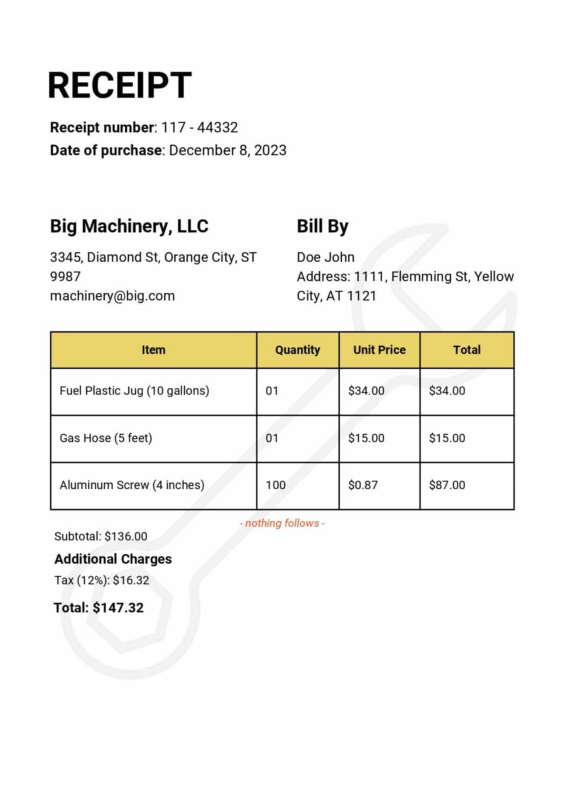

In [27]:
# read the image
from PIL import Image
import matplotlib.pyplot as plt

image = Image.open("./assets/receipt_1.jpg")

# display the image bigger
plt.figure(figsize=(15, 10))
plt.imshow(image)
plt.axis("off")
plt.show()

In [83]:
from instructor.multimodal import Image


def read_images(image_paths: List[str]) -> Receipt:
    """
    Given a list of image paths, identify the competitors in the images.
    """
    receipt, completion = ins_client.chat.completions.create_with_completion(
        model="gpt-4o-mini",
        response_model=Receipt,
        max_tokens=2048,
        temperature=0,
        messages=[
            {
                "role": "user",
                "content": [
                    "What is in this image?",
                    *[Image.from_path(path) for path in image_paths],
                ],
            }
        ],
    )
    print(completion.usage)
    return receipt

In [ ]:
receipt = read_images(["./assets/receipt_1.jpg"])
print(receipt)

#### How can we improve what we print out?

---
### Using OpenRouter keys with `instructor`

In [81]:
openrouter_api_key = getpass()

In [ ]:
from openai import OpenAI
import instructor
from pydantic import BaseModel


class User(BaseModel):
    name: str
    age: int


client = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=openrouter_api_key,
)

openrouter_client = instructor.from_openai(client)

resp = openrouter_client.chat.completions.create(
    model="mistralai/magistral-medium-2506",
    messages=[
        {
            "role": "user",
            "content": "Ivan is 28 years old",
        },
    ],
    response_model=User,
    extra_body={"provider": {"require_parameters": True}},
)

print(resp)

### Appendix

- [instructor cookbook](https://python.useinstructor.com/examples/planning-tasks/)
- 